In [6]:
# %% [markdown]
"""
## Explicit Parameter Definitions

Sets all required parameters explicitly to ensure reproducibility and avoid assumptions.
"""

# %%
# General settings
organics = ['MPD', 'EG', 'THB', 'BTY', 'DHB', 'CB']
time_limit = 60             # Time axis limit in minutes
sampling = 10               # Downsampling interval (every nth data point)

# Figure dimensions (suitable for a two-column journal layout)
fig_w_cm = 14               # Figure width in centimeters
fig_h_cm = 18               # Figure height in centimeters
cm2in = 1 / 2.54            # Conversion factor from centimeters to inches

# Excel filenames for data sources
excel_map = {
    'Al': 'alucone.xlsx',
    'Zn': 'zincone.xlsx'
}

# Colormap definitions for clarity and consistency
import matplotlib.pyplot as plt
cmap = plt.get_cmap('viridis')
colors = {
    ('Al', False): cmap(0.2),
    ('Al', True):  cmap(0.5),
    ('Zn', False): cmap(0.8),
    ('Zn', True):  cmap(0.9),
}

# Data preprocessing and global axis limits (ensure these are calculated)
import pandas as pd
import numpy as np

def preprocess_series(x, y, limit, step):
    """Normalize, filter, and downsample."""
    y_norm = y / y.iloc[0] if y.iloc[0] != 0 else y
    mask = x <= limit
    return (
        x[mask].iloc[::step].reset_index(drop=True),
        y_norm[mask].iloc[::step].reset_index(drop=True)
    )

# Load and preprocess data
data = {}
for metal, fname in excel_map.items():
    df = pd.read_excel(fname)
    cols = df.columns.tolist()
    pairs = [(cols[i], cols[i+1]) for i in range(0, len(cols), 2) if i+1 < len(cols)]
    metal_dict = {}
    for xcol, ycol in pairs:
        uv = ycol.endswith(' UV')
        org = ycol.replace(' UV', '')
        if org in organics:
            x_proc, y_proc = preprocess_series(df[xcol], df[ycol], time_limit, sampling)
            metal_dict.setdefault(org, {})[uv] = (x_proc, y_proc)
    data[metal] = metal_dict

# Global axis limits calculation
all_x = np.concatenate([
    arr[0].values
    for md in data.values()
    for series in md.values()
    for arr in series.values()
])
all_y = np.concatenate([
    arr[1].values
    for md in data.values()
    for series in md.values()
    for arr in series.values()
])

x_min, x_max = all_x.min(), all_x.max()
y_min, y_max = 0, all_y.max() * 1.15  # add extra 15% space for clarity


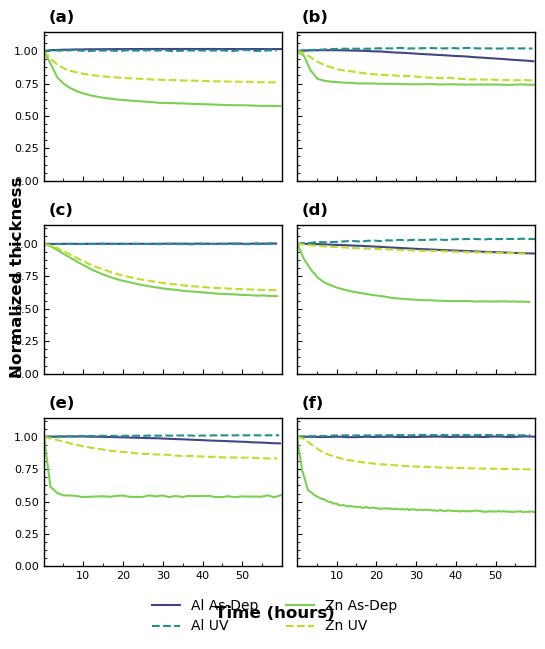

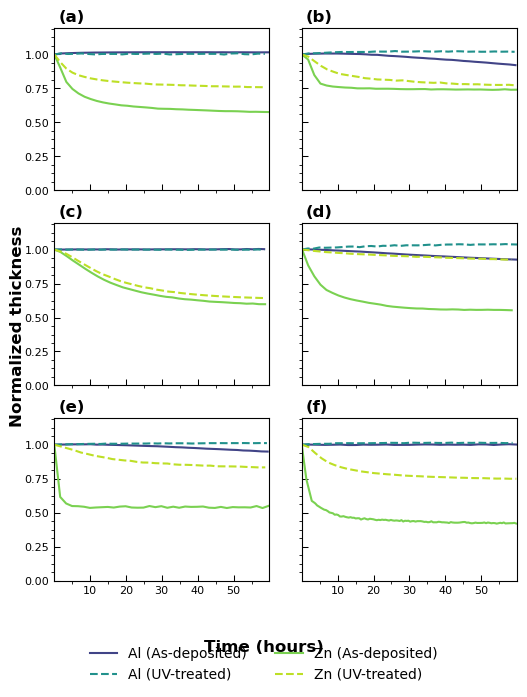

In [7]:
# %% [markdown]
"""
## Final Polished Six-Panel Figure

Generates a journal-ready, six-panel figure comparing normalized thickness changes for Al- and Zn-based hybrid films. Includes panel labels (a–f), shared axis labels, clearly positioned legend, and optimized whitespace for clarity and readability.
"""

# %%
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import os

# Create output directory
outdir = 'airstab_fig'
os.makedirs(outdir, exist_ok=True)

# Figure and subplots setup
fig, axes = plt.subplots(
    nrows=3, ncols=2,
    figsize=(fig_w_cm * cm2in, fig_h_cm * cm2in),
    sharex=True, sharey=True
)
axes = axes.flatten()

# Panel labels
panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

# Plotting loop for each panel
for idx, org in enumerate(organics):
    ax = axes[idx]

    # Plot Al and Zn chemistries, both UV-treated and as-deposited
    for metal in ['Al', 'Zn']:
        series = data.get(metal, {}).get(org, {})
        for uv_flag, linestyle in [(False, '-'), (True, '--')]:
            if uv_flag in series:
                x, y = series[uv_flag]
                label = f"{metal} ({'UV-treated' if uv_flag else 'As-deposited'})"
                ax.plot(
                    x, y,
                    color=colors[(metal, uv_flag)],
                    linestyle=linestyle,
                    linewidth=1.5,
                    label=label if idx == 0 else None  # avoid duplicate legend entries
                )

    # Add panel labels (a–f)
    ax.text(
        0.02, 1.02, panel_labels[idx],
        transform=ax.transAxes,
        fontsize=12, fontweight='bold',
        verticalalignment='bottom', horizontalalignment='left'
    )

    # Axes configuration
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(0.25))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(direction='in', length=4, width=0.75, labelsize=8)
    for spine in ax.spines.values():
        spine.set_linewidth(0.8)

# Hide any unused subplots
for i in range(len(organics), len(axes)):
    axes[i].axis('off')

# Unified legend at the bottom center
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    ncol=2, fontsize=10,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.02),
    frameon=False
)

# Shared axis labels positioned clearly
fig.text(
    0.5, 0.04, 'Time (hours)',
    horizontalalignment='center',
    fontsize=12, fontweight='bold'
)
fig.text(
    0.04, 0.5, 'Normalized thickness',
    verticalalignment='center',
    rotation='vertical',
    fontsize=12, fontweight='bold'
)

# Optimize layout spacing carefully
fig.subplots_adjust(
    left=0.12, right=0.96,
    bottom=0.14, top=0.92,
    wspace=0.15, hspace=0.2
)

# Save figure in high resolution
fig.savefig(
    os.path.join(outdir, 'air_stability_final_figure.png'),
    dpi=300, bbox_inches='tight'
)

# Display figure inline
plt.show()


In [8]:
# %% [markdown]
"""
## Parameters and Data Loading

Defines organics, plotting parameters, and loads preprocessed thickness data for Alucone and Zincone films.
"""

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import os

# General parameters
organics = ['MPD', 'EG', 'THB', 'BTY', 'DHB', 'CB']
time_limit = 60  # minutes
sampling = 10    # downsample rate
fig_w_cm = 14
fig_h_cm = 18
cm2in = 1 / 2.54

# File paths
excel_map = {
    'Al': 'alucone.xlsx',
    'Zn': 'zincone.xlsx'
}

# Colors for each material/treatment
cmap = plt.get_cmap('viridis')
colors = {
    ('Al', False): cmap(0.2),
    ('Al', True):  cmap(0.5),
    ('Zn', False): cmap(0.8),
    ('Zn', True):  cmap(0.9),
}

# Preprocessing function
def preprocess_series(x, y, limit, step):
    y_norm = y / y.iloc[0] if y.iloc[0] != 0 else y
    mask = x <= limit
    return (
        x[mask].iloc[::step].reset_index(drop=True),
        y_norm[mask].iloc[::step].reset_index(drop=True)
    )

# Load and preprocess data
data = {}
for metal, fname in excel_map.items():
    df = pd.read_excel(fname)
    cols = df.columns.tolist()
    pairs = [(cols[i], cols[i+1]) for i in range(0, len(cols), 2) if i+1 < len(cols)]
    metal_dict = {}
    for xcol, ycol in pairs:
        uv = ycol.endswith(' UV')
        org = ycol.replace(' UV', '')
        if org in organics:
            x_proc, y_proc = preprocess_series(df[xcol], df[ycol], time_limit, sampling)
            metal_dict.setdefault(org, {})[uv] = (x_proc, y_proc)
    data[metal] = metal_dict

# Global axis limits
all_x = np.concatenate([
    arr[0].values
    for md in data.values()
    for series in md.values()
    for arr in series.values()
])
all_y = np.concatenate([
    arr[1].values
    for md in data.values()
    for series in md.values()
    for arr in series.values()
])

x_min, x_max = all_x.min(), all_x.max()
y_min, y_max = 0, all_y.max() * 1.15  # 15% headroom


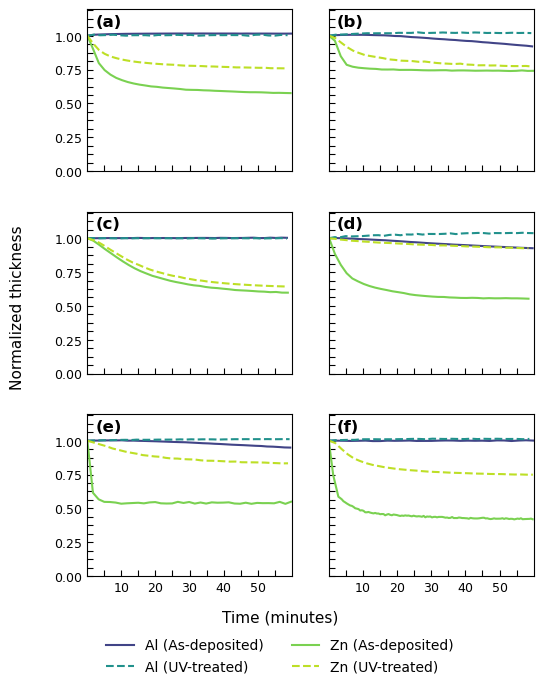

In [16]:
# %% [markdown]
"""
## Final Polished Air Stability Figure (Six Panels)

Creates a fully polished, journal-ready six-panel figure showing normalized thickness decay in air for Al- and Zn-based hybrid films (as-deposited and UV-treated), with tight layout, proper panel labels, axis labels, and a clean unified legend.
"""

# %%
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

# Create output folder
outdir = 'airstab_fig'
os.makedirs(outdir, exist_ok=True)

# Create figure and axes
fig, axes = plt.subplots(
    nrows=3, ncols=2,
    figsize=(fig_w_cm * cm2in, fig_h_cm * cm2in),
    sharex=True, sharey=True
)
axes = axes.flatten()

# Panel labels
panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

# Plotting loop
for idx, org in enumerate(organics):
    ax = axes[idx]
    
    for metal in ['Al', 'Zn']:
        series = data.get(metal, {}).get(org, {})
        for uv_flag, linestyle in [(False, '-'), (True, '--')]:
            if uv_flag in series:
                x, y = series[uv_flag]
                label = f"{metal} ({'UV-treated' if uv_flag else 'As-deposited'})"
                ax.plot(
                    x, y,
                    color=colors[(metal, uv_flag)],
                    linestyle=linestyle,
                    linewidth=1.5,
                    label=label if idx == 0 else None  # label only once for legend
                )

    # Add panel label inside the plot
    ax.text(
        0.04, 0.97, panel_labels[idx],
        transform=ax.transAxes,
        fontsize=12, fontweight='bold',
        va='top', ha='left'
    )
    
    # Set limits and ticks
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(0.25))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(
        direction='in', which='both',
        length=4, width=0.8, labelsize=9
    )
    for spine in ax.spines.values():
        spine.set_linewidth(0.8)

# Hide any unused subplots
for i in range(len(organics), len(axes)):
    axes[i].axis('off')

# Unified legend at bottom
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    ncol=2, fontsize=10,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.035),
    frameon=False
)

# Axis labels
fig.text(
    0.5, 0.055, 'Time (minutes)',
    ha='center', fontsize=11, fontweight='normal'
)
fig.text(
    0.01, 0.5, 'Normalized thickness',
    va='center', rotation='vertical',
    fontsize=11, fontweight='normal'
)

# Layout adjustment
fig.subplots_adjust(
    left=0.15, right=0.96,
    bottom=0.12, top=0.92,
    wspace=0.18, hspace=0.25
)

# Save final figure
fig.savefig(
    os.path.join(outdir, 'air_stability_final.png'),
    dpi=300, bbox_inches='tight'
)
fig.savefig(
    os.path.join(outdir, 'air_stability_final.pdf'),
    bbox_inches='tight'
)

# Display figure inline
plt.show()
